In [1]:
import pandas as pd
import rdkit.Chem as Chem
from rdkit.Chem import rdMolDescriptors

This notebook contains some more statistics and visualizations of the molecular contents of the compounds in the data. 

In [2]:
data = pd.read_csv('Data_set/all_compounds-umbrella.csv')
data = data.set_index('CID')

# Mol weights

In [110]:
data['mol'] = data['IsomericSMILES'].apply(Chem.MolFromSmiles)
data['num_atoms'] = data['mol'].apply(rdMolDescriptors.CalcNumAtoms)
data['num_heavy_atoms'] = data['mol'].apply(rdMolDescriptors.CalcNumHeavyAtoms)

data[ 'mol_weight'] = data['mol'].apply(rdMolDescriptors.CalcExactMolWt)



In [111]:
y = data[data.columns[4:15]]
data = data.drop(data.columns[4:15], axis=1)

In [112]:
y.columns

Index(['alcohol', 'animal', 'aquatic', 'earthy', 'flower', 'fruity', 'green',
       'herbal', 'savory', 'spices', 'woody'],
      dtype='object')

In [113]:
print(data['mol_weight'].min(), data['mol_weight'].max())

27.010899031999998 696.4349668799999


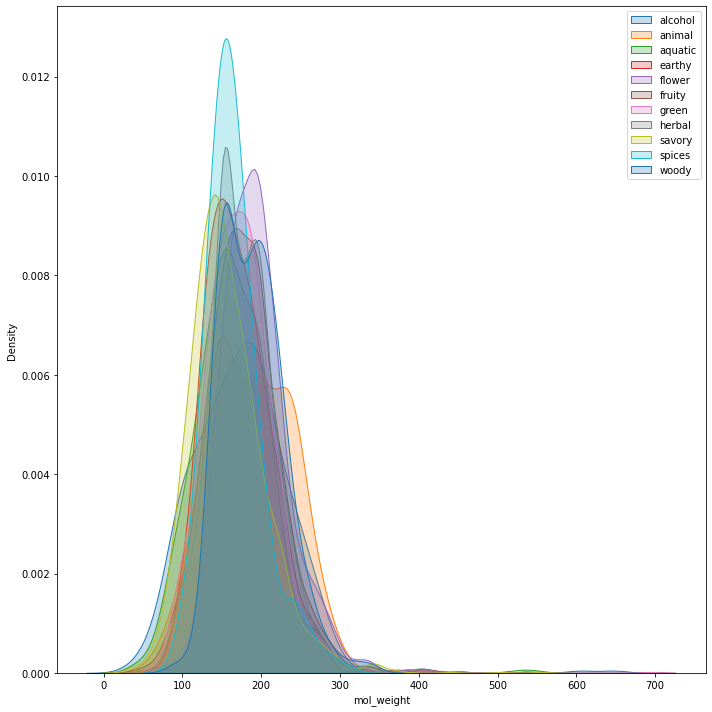

In [114]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))

for col in y.columns:
    sns.kdeplot(data=data.loc[y.index[y[col] == 1].tolist()]['mol_weight'], ax=ax, fill=True, label=col, palette="crest")
    ax.legend()
    
plt.tight_layout()
#plt.savefig('../images/mol_weight.png', dpi=300)

In [116]:
#Count types of atoms
from collections import Counter
from rdkit.Chem import rdchem

def count_atoms(mol):
    atoms = [atom.GetSymbol() for atom in mol.GetAtoms()]
    return Counter(atoms)

data['atom_counts'] = data['mol'].apply(count_atoms)

#get percentage of molecules contains each atom
def get_atom_percent(atom, atom_counts):
    count = 0
    
    for atom_count in atom_counts:
        for key, value in atom_count.items():
            if key == atom:
                count += 1

    return count / len(atom_counts)

    
atom_percent = {}

for atom in ['C', 'N', 'O', 'S', 'P']:
    atom_percent[atom] = get_atom_percent(atom, data['atom_counts']) * 100

#Change dictionary to dataframe
atom_percent = pd.DataFrame.from_dict(atom_percent, orient='index', columns=['percent'])
atom_percent = atom_percent.sort_values(by='percent', ascending=False)
atom_percent

,percent
C,99.969428
O,88.612045
S,11.372669
N,9.889942
P,0.015286


c:\Users\Stijn\anaconda3\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
c:\Users\Stijn\anaconda3\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
c:\Users\Stijn\anaconda3\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
c:\Users\Stijn\anaconda3\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
c:\Users\Stijn\anaconda3\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance

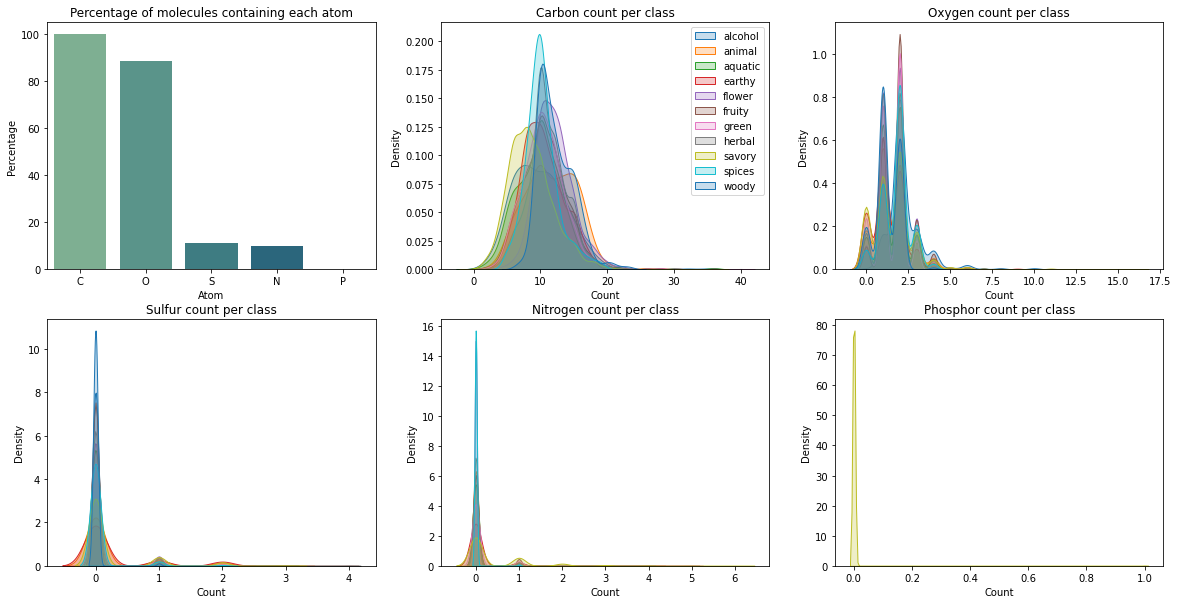

In [117]:
from rdkit import Chem
from rdkit.Chem import Draw

mols = data.loc[y.index[y['alcohol'] == 1].tolist()]['mol'].tolist()

#Make barplot of atom counts throughout dataset
fig, axes = plt.subplots(2, 3, figsize=(20, 10))

sns.barplot(x=atom_percent.index, y='percent', data=atom_percent, ax=axes[0][0], palette="crest")
axes[0][0].set_xlabel('Atom')
axes[0][0].set_ylabel('Percentage')
axes[0][0].set_title('Percentage of molecules containing each atom')

for col in y.columns:
    sns.kdeplot(data=data.loc[y.index[y[col] == 1].tolist()]['atom_counts'].apply(lambda x: x['C']), ax=axes[0][1], fill=True, label=col, palette="crest")
    axes[0][1].set_xlabel('Count')
    axes[0][1].set_title('Carbon count per class')
    axes[0][1].legend()

for col in y.columns:
    sns.kdeplot(data=data.loc[y.index[y[col] == 1].tolist()]['atom_counts'].apply(lambda x: x['O']), ax=axes[0][2], fill=True, label=col, palette="crest")
    axes[0][2].set_xlabel('Count')
    axes[0][2].set_title('Oxygen count per class')

for col in y.columns:
    sns.kdeplot(data=data.loc[y.index[y[col] == 1].tolist()]['atom_counts'].apply(lambda x: x['S']), ax=axes[1][1], fill=True, label=col, palette="crest")
    axes[1][0].set_xlabel('Count')
    axes[1][0].set_title('Sulfur count per class')


for col in y.columns:
    sns.kdeplot(data=data.loc[y.index[y[col] == 1].tolist()]['atom_counts'].apply(lambda x: x['N']), ax=axes[1][0], fill=True, label=col, palette="crest")
    axes[1][1].set_xlabel('Count')
    axes[1][1].set_title('Nitrogen count per class')

for col in y.columns:
    sns.kdeplot(data=data.loc[y.index[y[col] == 1].tolist()]['atom_counts'].apply(lambda x: x['P']), ax=axes[1][2], fill=True, label=col, palette="crest")
    axes[1][2].set_xlabel('Count')
    axes[1][2].set_title('Phosphor count per class')

plt.savefig('../images/atom_counts.png', dpi=300)

In [156]:
from rdkit.Chem.Fragments import fr_ester, fr_Al_COO
from rdkit.Chem import Fragments

#Gathering the fragment counts for each class of molecule to find fragments that are more common in one class than the others

fragments = [k for k , f in Fragments.__dict__.items() if callable(f)]

#Drop strings from list not starting with "fr_"
fragments = [x for x in fragments if x.startswith('fr_')]

fragment_counts = pd.DataFrame(index=data.index)

for fragment in fragments:
    fragment_counts[fragment] = data['mol'].apply(lambda x: getattr(Fragments, fragment)(x))

#Drop columns with all zeros
print("Shape before: ", fragment_counts.shape)
fragment_counts = fragment_counts.loc[:, (fragment_counts != 0).any(axis=0)]

#Find columns with highest variance
feat = fragment_counts.var().sort_values(ascending=False).head(1).index.tolist()


feat_percent = pd.DataFrame(index=y.columns, columns=fragment_counts.columns)

for feat in fragment_counts.columns:
    for col in y.columns:
        class_mols = fragment_counts.loc[y.index[y[col] == 1].tolist()][feat]

        feat_percent.loc[col][feat] = class_mols.mean()

feat_percent

Shape before:  (6542, 85)


,fr_C_O,fr_C_O_noCOO,fr_Al_OH,fr_Ar_OH,fr_methoxy,fr_oxime,fr_ester,fr_Al_COO,fr_Ar_COO,fr_COO,...,fr_nitro_arom_nonortho,fr_phenol_noOrthoHbond,fr_Al_OH_noTert,fr_para_hydroxylation,fr_allylic_oxid,fr_aryl_methyl,fr_Ndealkylation1,fr_Ndealkylation2,fr_ketone_Topliss,fr_ArN
alcohol,0.888672,0.880859,0.166016,0.001953,0.136719,0.0,0.722656,0.025391,0.0,0.025391,...,0.0,0.001953,0.158203,0.013672,0.291016,0.017578,0.0,0.0,0.09375,0.007812
animal,0.596932,0.555091,0.200837,0.033473,0.103208,0.0,0.298466,0.043236,0.002789,0.046025,...,0.0,0.033473,0.152022,0.055788,0.467225,0.20781,0.0,0.002789,0.149233,0.008368
aquatic,0.636145,0.628916,0.169478,0.014458,0.131727,0.00241,0.351807,0.012851,0.0,0.012851,...,0.0,0.013655,0.131727,0.037751,0.722892,0.059438,0.0,0.000803,0.086747,0.001606
earthy,0.409901,0.40396,0.259406,0.029703,0.160396,0.00198,0.209901,0.007921,0.0,0.007921,...,0.0,0.029703,0.168317,0.037624,0.479208,0.281188,0.0,0.0,0.106931,0.0
flower,0.685687,0.677128,0.178792,0.033286,0.148359,0.001427,0.398478,0.009035,0.0,0.009035,...,0.0,0.033286,0.127437,0.087494,0.929624,0.115074,0.0,0.000476,0.107941,0.013314
fruity,0.826515,0.797908,0.124577,0.015995,0.117502,0.001538,0.540449,0.032605,0.000615,0.033221,...,0.0,0.013842,0.103045,0.038757,0.808982,0.06152,0.0,0.000308,0.104276,0.008305
green,0.618081,0.595018,0.133764,0.016144,0.126384,0.002768,0.350092,0.023985,0.000461,0.024446,...,0.0,0.015683,0.109779,0.034133,0.827491,0.114391,0.0,0.0,0.065037,0.002768
herbal,0.66335,0.648977,0.181316,0.034273,0.095633,0.001106,0.339414,0.016031,0.000553,0.016584,...,0.0,0.03372,0.127695,0.042565,0.804865,0.090658,0.0,0.000553,0.166943,0.002764
savory,0.651534,0.580916,0.156368,0.049601,0.123161,0.0,0.277848,0.069357,0.002102,0.071459,...,0.00042,0.046658,0.143758,0.046238,0.410677,0.20765,0.001261,0.000841,0.157209,0.002102
spices,0.651757,0.642173,0.079872,0.070288,0.345048,0.0,0.351438,0.009585,0.0,0.009585,...,0.0,0.070288,0.060703,0.115016,0.571885,0.178914,0.0,0.0,0.111821,0.0


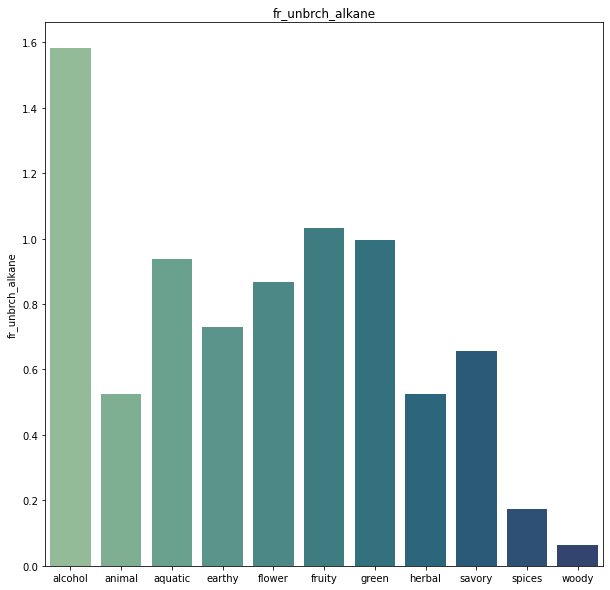

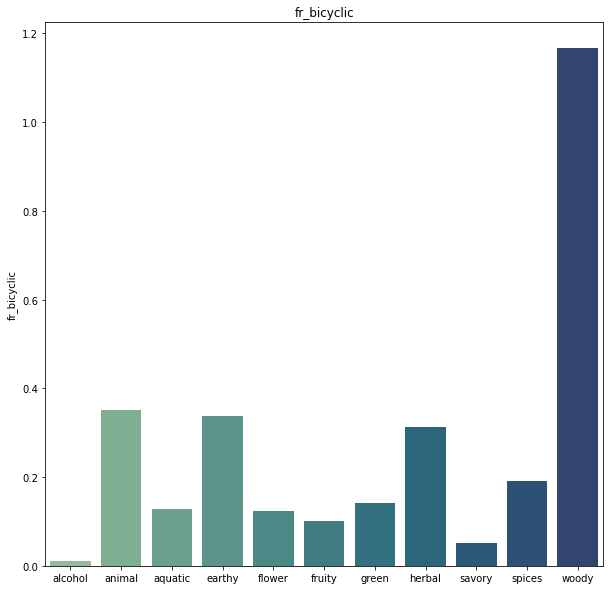

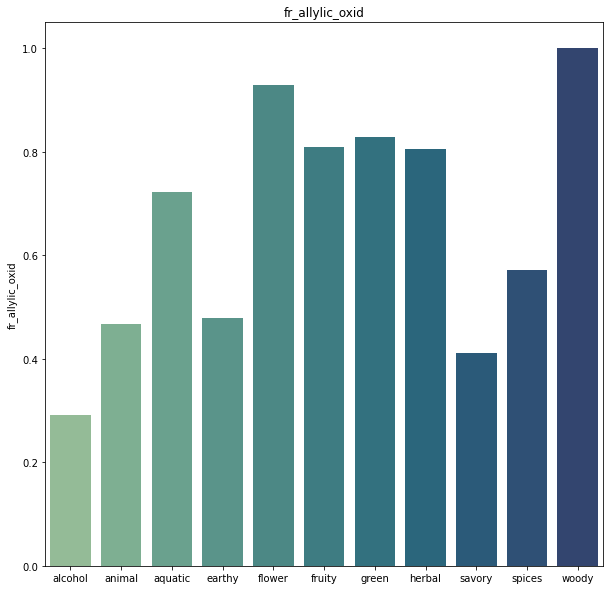

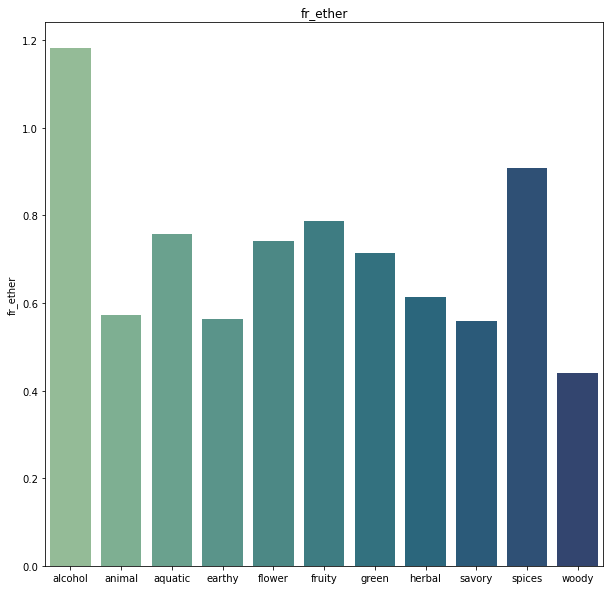

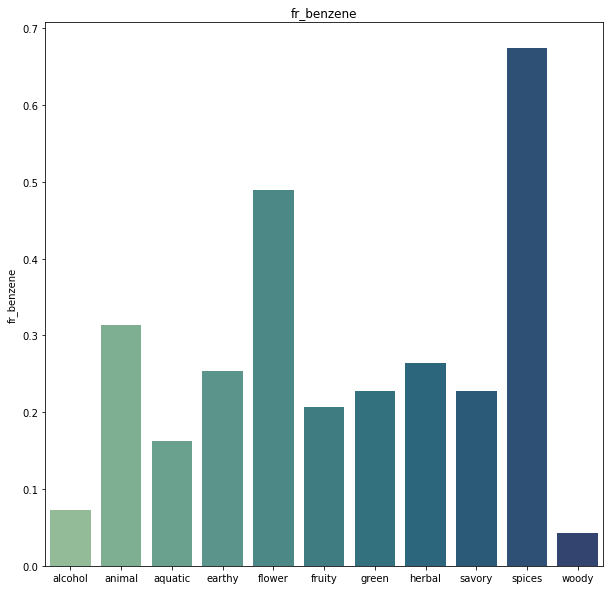

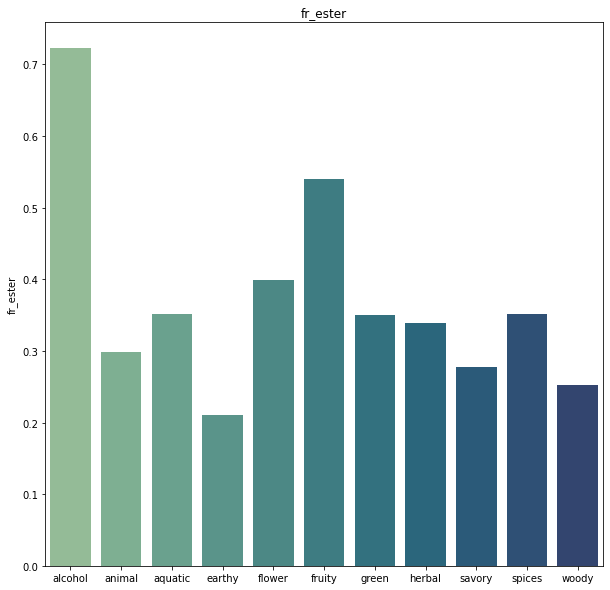

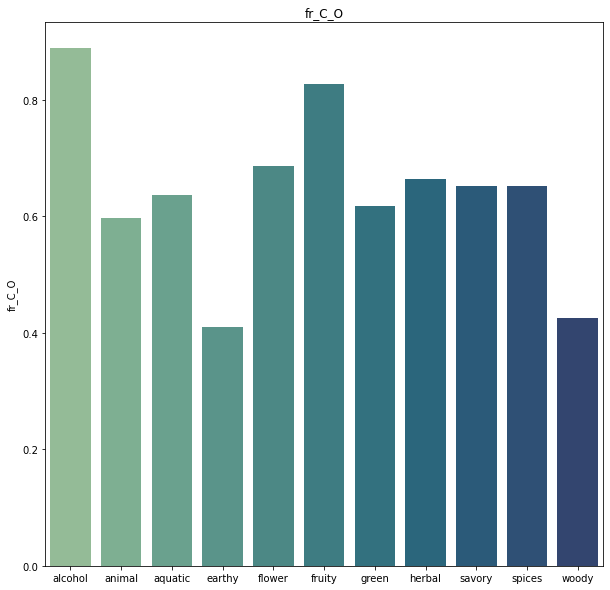

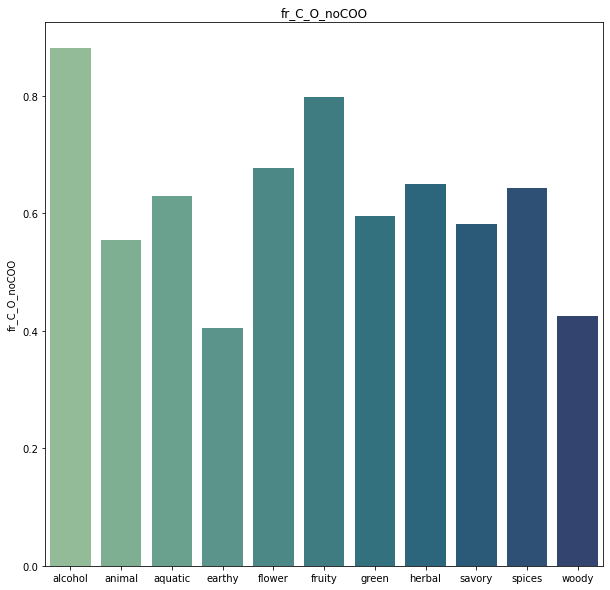

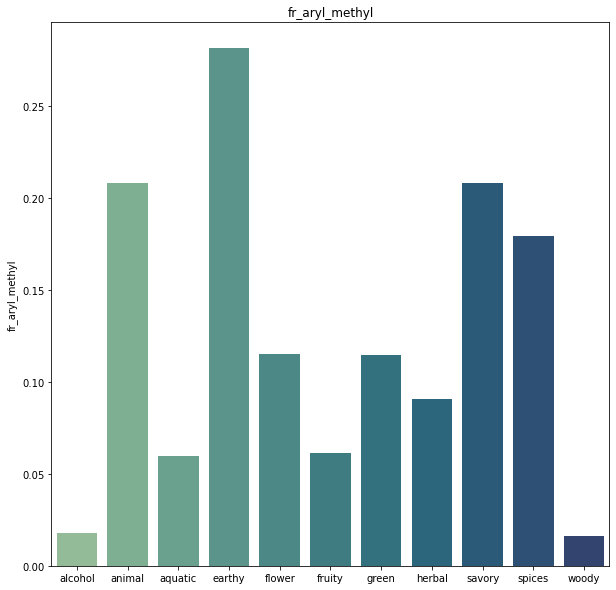

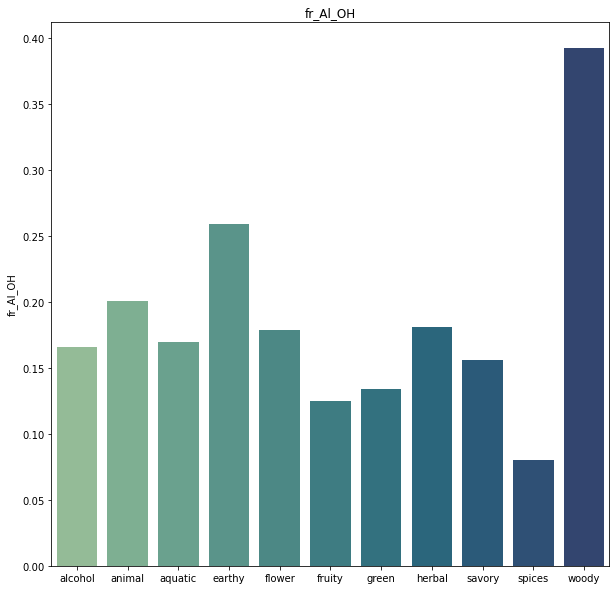

In [221]:
#Find columns with highest variance
var = feat_percent.var().sort_values(ascending=False).head(10).index.tolist()

for f in var:
    fig, ax = plt.subplots(figsize=(10, 10))

    d = pd.DataFrame(feat_percent[f], columns=[f], index=feat_percent.index)

    sns.barplot(x=d.index, y=f, data=d, ax=ax, palette="crest")
    ax.set_title(f)
    plt.savefig('../images/fragments/{}.png'.format(f), dpi=300, transparent=False)

In [202]:
from torchmetrics.classification import BinaryF1Score, MultilabelF1Score,MultilabelAUROC, MultilabelPrecision, MultilabelRecall, BinaryAUROC
import torch

def get_test_metrics_rf(clf, X, y, num_labels):
    results_per_class = pd.DataFrame(columns=["AUROC", "F1", "Precision", "Recall"], index=y.columns)
    results_per_class = results_per_class.fillna(0)

    y_hat = clf.predict(X)

    auroc_per_class = pd.Series(MultilabelAUROC(num_labels=num_labels, average=None)(torch.tensor(y_hat, dtype=torch.float), torch.tensor(y.values, dtype=torch.long)).numpy(), index=y.columns)
    f1_per_class = pd.Series(MultilabelF1Score(num_labels=num_labels, average=None)(torch.tensor(y_hat, dtype=torch.float), torch.tensor(y.values, dtype=torch.float)).numpy(), index=y.columns)
    precision_per_class = pd.Series(MultilabelPrecision(num_labels=num_labels, average=None)(torch.tensor(y_hat, dtype=torch.float), torch.tensor(y.values, dtype=torch.float)).numpy(), index=y.columns)
    recall_per_class = pd.Series(MultilabelRecall(num_labels=num_labels, average=None)(torch.tensor(y_hat, dtype=torch.float), torch.tensor(y.values, dtype=torch.float)).numpy(), index=y.columns)

    df = pd.DataFrame({"AUROC": auroc_per_class, "F1": f1_per_class, "Precision": precision_per_class, "Recall": recall_per_class})
    results_per_class = results_per_class.add(df, fill_value=0)

    results_per_class.loc["Average"] = results_per_class.mean()

    return results_per_class, y_hat

def load_train_data():
    train_data = pd.read_csv("../Data/data_split/train.csv")
    train_data.set_index("CID", inplace=True)

    # #Drop majority classes
    # train_data = train_data.drop(columns=['woody'])
    # train_data = train_data.drop(columns=['spices'])
    # train_data = train_data.drop(columns=['earthy'])
    # train_data = train_data.drop(columns=['aquatic'])
    # train_data = train_data.drop(columns=['alcohol'])
    # train_data = train_data.drop(columns=['animal'])


    features = pd.read_csv("../Data/mordred_features-final_selection-imputed.csv")
    features.set_index("CID", inplace=True)

    X = features.reindex(index=train_data.index)
    y = train_data.iloc[:, -11:]

    #Drop all rows in y that are all 0's (no classes)
    to_be_dropped = y.loc[~(y==0).all(axis=1)].index
    y = y.loc[to_be_dropped]
    X = X.loc[to_be_dropped]

    return X, y

def load_test_data():
    test_data = pd.read_csv("../Data/data_split/test.csv")
    test_data.set_index("CID", inplace=True)

    #Drop majority classes
    # test_data = test_data.drop(columns=['woody'])
    # test_data = test_data.drop(columns=['spices'])
    # test_data = test_data.drop(columns=['earthy'])
    # test_data = test_data.drop(columns=['aquatic'])
    # test_data = test_data.drop(columns=['alcohol'])
    # test_data = test_data.drop(columns=['animal'])

    features = pd.read_csv("../Data/mordred_features-final_selection-imputed.csv")
    features.set_index("CID", inplace=True)

    y = test_data.iloc[:, -11:]
    X = features.reindex(index=test_data.index)

    #Drop all rows in y that are all 0's (no classes)
    to_be_dropped = y.loc[~(y==0).all(axis=1)].index
    y = y.loc[to_be_dropped]
    X = X.loc[to_be_dropped]

    return X, y

In [219]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

X_train, y_train = load_train_data()
X_test, y_test = load_test_data()

#Drop columns with a variance < 0.1
print("Shape before: ", fragment_counts.shape)
fragment_counts = fragment_counts.loc[:, fragment_counts.var() > 0.2]
print("Shape after: ", fragment_counts.shape)

train_fragment_counts = fragment_counts.loc[X_train.index]
test_fragment_counts = fragment_counts.loc[X_test.index]

# scaler = StandardScaler()
# train_fragment_counts = scaler.fit_transform(train_fragment_counts)
# test_fragment_counts = scaler.transform(test_fragment_counts)

pca = PCA(n_components=5)

train_fragment_counts = pca.fit_transform(train_fragment_counts)
test_fragment_counts = pca.transform(test_fragment_counts)

pca.explained_variance_ratio_

#Add first principal component to X_train and X_test
X_train['pca1_frags'] = train_fragment_counts[:, 0]
X_test['pca1_frags'] = test_fragment_counts[:, 0]

X_train['pca2_frags'] = train_fragment_counts[:, 1]
X_test['pca2_frags'] = test_fragment_counts[:, 1]

X_train = X_train[['BCUTv-1h', 'pca1_frags', 'pca2_frags']]

pca = PCA(n_components=79)
pca.fit(X_train)
pca.explained_variance_ratio_

# clf = XGBClassifier()
# clf.fit(X_train, y_train)

Shape before:  (6542, 10)
Shape after:  (6542, 10)


array([7.27192345e-01, 7.39762965e-02, 6.20515650e-02, 4.66567890e-02,
       2.01551252e-02, 1.37500516e-02, 1.22134140e-02, 9.34631267e-03,
       6.28125428e-03, 5.57920964e-03, 4.34381705e-03, 3.09658451e-03,
       2.49461888e-03, 2.03306222e-03, 1.52133648e-03, 1.39837880e-03,
       1.34702653e-03, 1.13003746e-03, 9.87851741e-04, 9.03924154e-04,
       6.31821128e-04, 5.75850243e-04, 5.35040868e-04, 3.92691538e-04,
       2.23609781e-04, 1.90829394e-04, 1.44402225e-04, 1.33450718e-04,
       1.30321609e-04, 9.13920108e-05, 7.37845615e-05, 5.87088996e-05,
       5.04013723e-05, 4.10541122e-05, 3.09466839e-05, 2.96878345e-05,
       2.74386272e-05, 2.19315327e-05, 2.09444018e-05, 2.07351910e-05,
       1.52222057e-05, 1.39855547e-05, 1.22013842e-05, 9.63355985e-06,
       8.84624693e-06, 7.91322196e-06, 6.36503616e-06, 5.98561279e-06,
       5.67814169e-06, 5.16604927e-06, 4.48871742e-06, 4.11618767e-06,
       3.20785390e-06, 2.28336073e-06, 2.02645615e-06, 1.59440784e-06,
      

<AxesSubplot:>

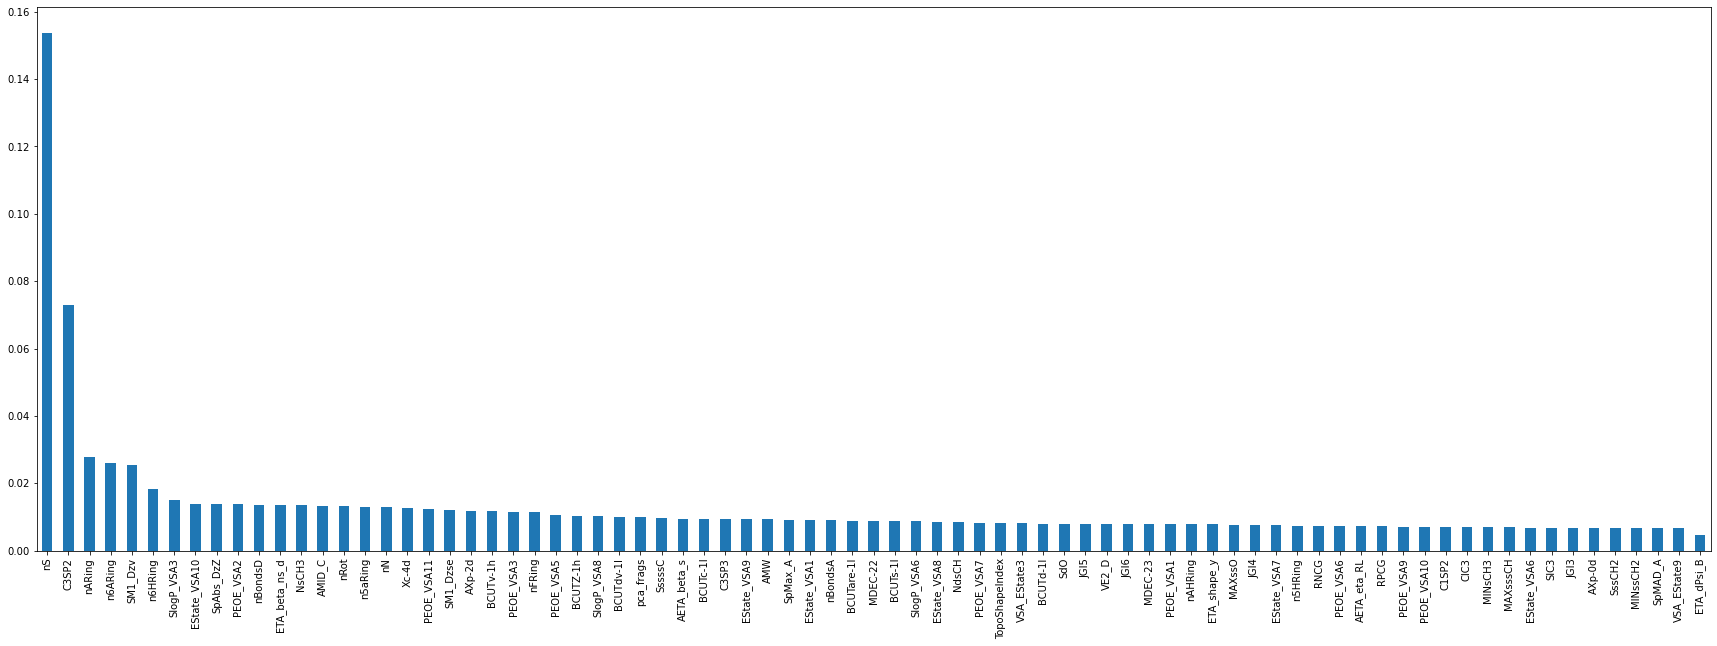

In [218]:
results_per_class, y_hat = get_test_metrics_rf(clf, X_test, y_test, 11)

#Plot feature importance
fig, ax = plt.subplots(figsize=(30, 10))

pd.Series(clf.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(79).plot.bar(ax=ax, color='C0')


In [206]:
results_per_class, y_hat = get_test_metrics_rf(clf, X_test, y_test, 11)
results_per_class

,AUROC,F1,Precision,Recall
alcohol,0.706974,0.500000,0.576923,0.441176
animal,0.672424,0.479263,0.702703,0.363636
aquatic,0.669138,0.477752,0.573034,0.409639
earthy,0.606858,0.311688,0.452830,0.237624
flower,0.742516,0.650633,0.696477,0.610451
fruity,0.746668,0.746768,0.738346,0.755385
green,0.722204,0.625917,0.666667,0.589862
herbal,0.678725,0.531605,0.643137,0.453039
savory,0.770763,0.706412,0.760291,0.659664
spices,0.627726,0.346939,0.485714,0.269841


In [93]:
ester_percent = {}

for col in y.columns:
    class_mols = data.loc[y.index[y[col] == 1].tolist()]['ester']
    
    #Get the number of rows where ester is bigger than 0
    ester_count = len(class_mols[class_mols > 0])

    #Get the percentage of molecules that contain ester
    ester_percent[col] = ester_count / len(class_mols) * 100

ester_percent = pd.DataFrame.from_dict(ester_percent, orient='index', columns=['percent'])
ester_percent

,percent
alcohol,64.257812
animal,27.894003
aquatic,33.333333
earthy,20.792079
flower,39.134570
fruity,51.245771
green,34.132841
herbal,32.946379
savory,26.229508
spices,34.824281


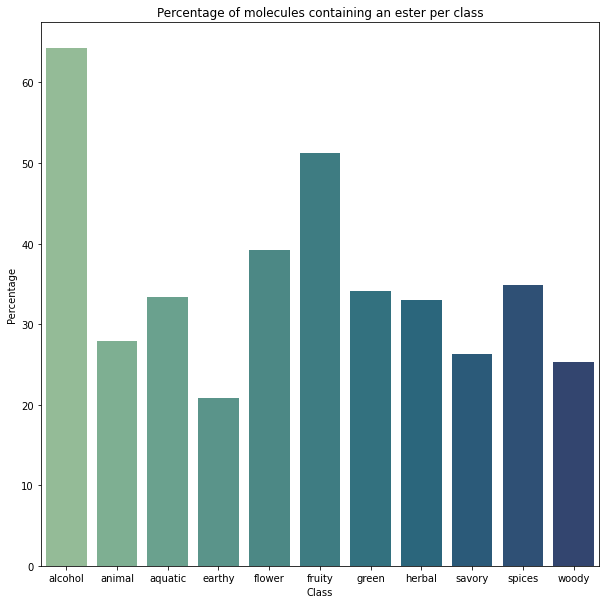

In [95]:
#Make barplot of what percentage of molecules in each class contain an ester
fig, ax = plt.subplots(figsize=(10, 10))

sns.barplot(x=ester_percent.index, y='percent',data=ester_percent,palette="crest")
ax.set_xlabel('Class')
ax.set_ylabel('Percentage')
ax.set_title('Percentage of molecules containing an ester per class')

plt.savefig('../images/ester_percent.png', dpi=300)

In [9]:
alcohol = data.loc[y.index[y[col] == 1]]
                   
import rdkit.Chem.AllChem as AllChem
import rdkit.DataStructs as DataStructs

fps = [AllChem.GetMorganFingerprintAsBitVect(m, 2, nBits=2024) for m in mols]

from tqdm import tqdm

#Create a similarity matrix
similarity_matrix = pd.DataFrame(index=alcohol.index, columns=alcohol.index)
similarity_matrix = similarity_matrix.fillna(0)

means = []

#Populate the similarity matrix
for i in tqdm(range(len(alcohol))):
    for j in range(len(alcohol)):
        similarity_matrix.iloc[i, j] = DataStructs.FingerprintSimilarity(fps[i], fps[j])

    row = similarity_matrix.iloc[i, :]
    row = row.drop(row.idxmax())

    mean = row.mean()
    means.append(mean)

means

100%|██████████| 186/186 [00:01<00:00, 106.71it/s]


[0.09340146326965831,
 0.1714441201499114,
 0.15226713400224404,
 0.2235587493618965,
 0.14840297520874635,
 0.1390655820460643,
 0.07242797136048212,
 0.159707459257554,
 0.10422863346189805,
 0.1768428742075741,
 0.0484891699012701,
 0.12041913578456302,
 0.2019021271674958,
 0.205503338117568,
 0.13803452777332123,
 0.16069721340050439,
 0.17590476860966378,
 0.12446398452389178,
 0.1923084430599398,
 0.24639334620222308,
 0.15434913608020948,
 0.018077723526277827,
 0.16718706366069094,
 0.09861720879360215,
 0.24412887029427557,
 0.24108084399682891,
 0.19976383837150313,
 0.22966337276240556,
 0.13734431353259277,
 0.05402514802654661,
 0.17178408250522664,
 0.19688580748284917,
 0.16873399672045794,
 0.15143001275332182,
 0.260548291959045,
 0.19729712199744256,
 0.28101552548492237,
 0.16717707421994943,
 0.2850792789085403,
 0.29328871109098625,
 0.31563017817869404,
 0.31563017817869404,
 0.25573638849281627,
 0.22741175628194638,
 0.1199088550794343,
 0.21237391343856268,
 0

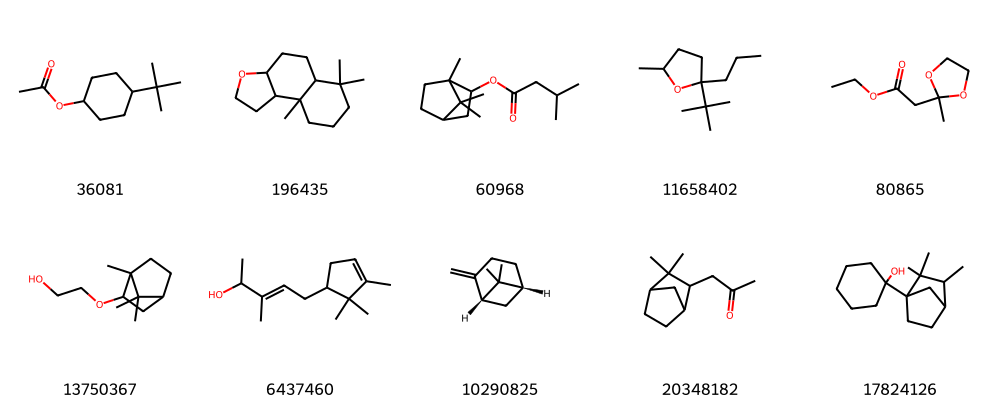

In [10]:
#Get index of 10 most similar compounds
most_similar = similarity_matrix.mean().sort_values(ascending=False)[:10].index.tolist()

#Draw the most similar compounds
Draw.MolsToGridImage(data.loc[most_similar]['mol'].tolist(), molsPerRow=5, subImgSize=(200, 200), legends=[str(i) for i in most_similar])

C:\Users\Stijn\AppData\Local\Temp\ipykernel_17928\1806029492.py:1: DeprecationWarning: The rdkit.Chem.MCS module is deprecated; please use rdkit.Chem.rdFMCS instead.
  from rdkit.Chem import MCS
C:\Users\Stijn\AppData\Local\Temp\ipykernel_17928\1806029492.py:3: DeprecationWarning: The rdkit.Chem.MCS module is deprecated; please use rdkit.Chem.rdFMCS instead.
  mcs = MCS.FindMCS(data.loc[most_similar]['mol'].tolist())


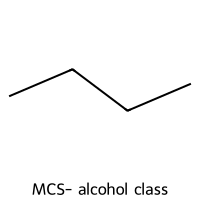

In [11]:
from rdkit.Chem import MCS

mcs = MCS.FindMCS(data.loc[most_similar]['mol'].tolist())

#Draw mcs
mcs_mol = Chem.MolFromSmarts(mcs.smarts)
mcs_img = Draw.MolToImage(mcs_mol, size=(200, 200), legend='MCS- alcohol class')
mcs_img

In [19]:
#Find and draw the MCS in each class
mcss = []

for col in y.columns:
    mols = data.loc[y.index[y[col] == 1].tolist()]['mol'].tolist()
    mcs = MCS.FindMCS(mols)

    #Check if the MCS is a valid SMARTS string
    if mcs.smarts != None:
        mcss.append((Chem.MolFromSmarts(mcs.smarts), col))

if len(mcss) == 1:
    dos = Draw.MolDrawOptions()
    dos.includeAtomTags = True
    mcs_img = Draw.MolToImage(mcss[0][0], size=(200, 200))


C:\Users\Stijn\AppData\Local\Temp\ipykernel_17928\2700948799.py:6: DeprecationWarning: The rdkit.Chem.MCS module is deprecated; please use rdkit.Chem.rdFMCS instead.
  mcs = MCS.FindMCS(mols)
C:\Users\Stijn\AppData\Local\Temp\ipykernel_17928\2700948799.py:6: DeprecationWarning: The rdkit.Chem.MCS module is deprecated; please use rdkit.Chem.rdFMCS instead.
  mcs = MCS.FindMCS(mols)
C:\Users\Stijn\AppData\Local\Temp\ipykernel_17928\2700948799.py:6: DeprecationWarning: The rdkit.Chem.MCS module is deprecated; please use rdkit.Chem.rdFMCS instead.
  mcs = MCS.FindMCS(mols)
C:\Users\Stijn\AppData\Local\Temp\ipykernel_17928\2700948799.py:6: DeprecationWarning: The rdkit.Chem.MCS module is deprecated; please use rdkit.Chem.rdFMCS instead.
  mcs = MCS.FindMCS(mols)
C:\Users\Stijn\AppData\Local\Temp\ipykernel_17928\2700948799.py:6: DeprecationWarning: The rdkit.Chem.MCS module is deprecated; please use rdkit.Chem.rdFMCS instead.
  mcs = MCS.FindMCS(mols)
C:\Users\Stijn\AppData\Local\Temp\ipyker

In [23]:
mcs_img

#Save the image
mcs_img.save('../images/mcs.png', dpi=300)

#Draw all woody compounds
Draw.MolsToGridImage(data.loc[y.index[y['woody'] == 1].tolist()]['mol'].tolist(), molsPerRow=5, subImgSize=(200, 200), legends=[str(i) for i in y.index[y['woody'] == 1].tolist()])

AttributeError: savefig

        CID                                     IsomericSMILES  \
2764  93405  CC(C)(C)C1=CC(=CC(=C1O)C(C)(C)C)CCC(=O)OCCNC(=...   

                                                   mol  num_atoms  \
2764  <rdkit.Chem.rdchem.Mol object at 0x7f1638723610>        110   

      num_heavy_atoms  mol_weight  
2764               50  696.434967  


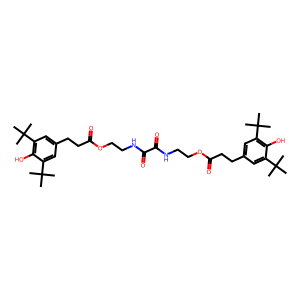

In [ ]:
#Find max weight compound and draw with rdkit
max_weight = odorants['mol_weight'].max()
max_weight_compound = odorants[odorants['mol_weight'] == max_weight]
print(max_weight_compound)

#Draw max weight compound
from rdkit.Chem import Draw
Draw.MolToImage(max_weight_compound['mol'].iloc[0])

c:\Users\Stijn\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


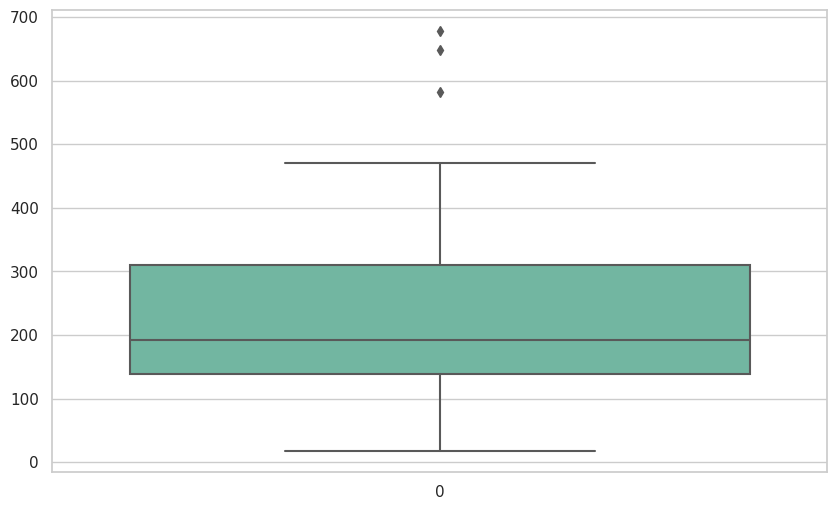

Min:  18.010564684
Max:  678.200728996
Mean:  228.24405332306918
Median:  192.02700259600002
Standard Deviation:  115.93511423311764


In [ ]:
#Boxplot distribution of molecular weights
plt.figure(figsize=(10, 6))
sns.boxplot(odorless['mol_weight'])
plt.show()

print('Min: ', odorless['mol_weight'].min())
print('Max: ', odorless['mol_weight'].max())
print('Mean: ', odorless['mol_weight'].mean())
print('Median: ', odorless['mol_weight'].median())
print('Standard Deviation: ', odorless['mol_weight'].std())

# Atoms

## Atom counts

<Figure size 720x432 with 0 Axes>

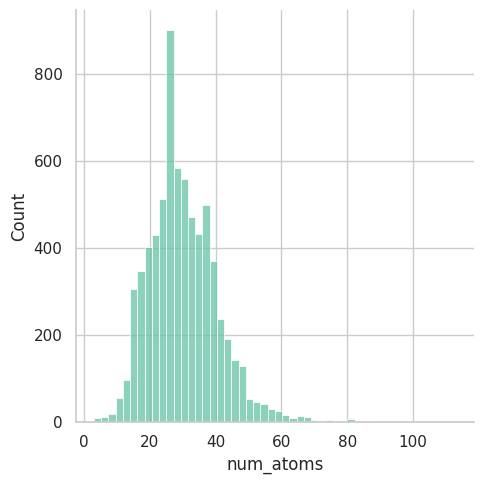

Min:  3
Max:  113


<Figure size 720x432 with 0 Axes>

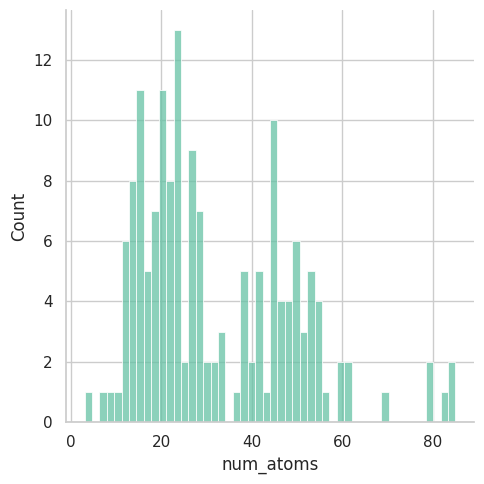

Min:  3
Max:  85


In [ ]:
#Plot distribution of number of atoms
plt.figure(figsize=(10, 6))
sns.displot(odorants['num_atoms'], kde=False, bins=50)
plt.show()

print('Min: ', odorants['num_atoms'].min())
print('Max: ', odorants['num_atoms'].max())

#Plot distribution of number of atoms for odorless odorants
plt.figure(figsize=(10, 6))
sns.displot(odorless['num_atoms'], kde=False, bins=50)
plt.show()

print('Min: ', odorless['num_atoms'].min())
print('Max: ', odorless['num_atoms'].max())

## Atom types

C    0.848136
O    0.130830
S    0.011290
N    0.009688
P    0.000056
dtype: float64


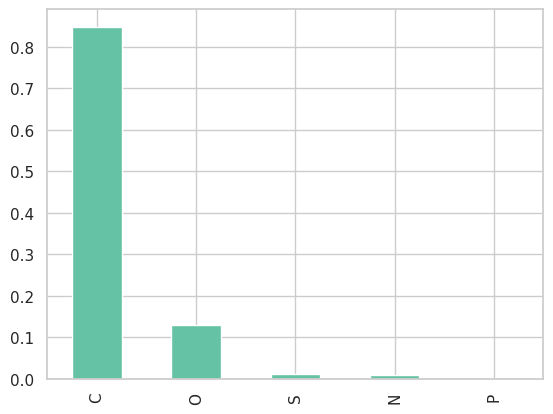

In [ ]:
#Get types of atoms in odorants
atoms = []
for i in range(len(odorants)):
    atoms.extend(odorants['mol'].iloc[i].GetAtoms())

atom_types = []
for atom in atoms:
    atom_types.append(atom.GetSymbol())

#Plot percentage of atom types in odorants
atom_types = pd.Series(atom_types)
print(atom_types.value_counts(normalize=True))
atom_types.value_counts(normalize=True).plot(kind='bar')
plt.show()

C    0.667324
O    0.272691
N    0.055249
S    0.003946
P    0.000789
dtype: float64


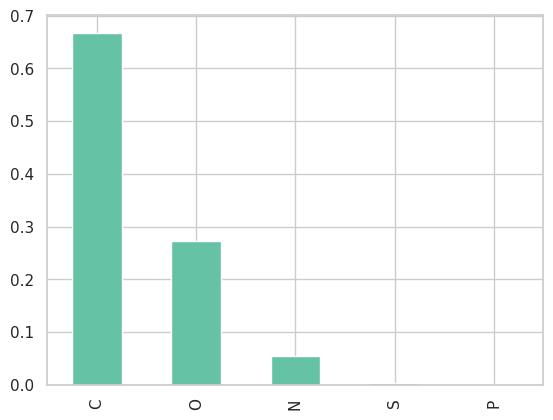

In [ ]:
#Get types of atoms in odorless
atoms = []
for i in range(len(odorless)):
    atoms.extend(odorless['mol'].iloc[i].GetAtoms())

atom_types = []
for atom in atoms:
    atom_types.append(atom.GetSymbol())

#Plot percentage of atom types in odorless
atom_types = pd.Series(atom_types)
print(atom_types.value_counts(normalize=True))
atom_types.value_counts(normalize=True).plot(kind='bar')
plt.show()

In [ ]:
#Boxplot how many of each atom type there are per odorant


## Bond types

Single      0.732766
Aromatic    0.164989
Double      0.100904
Triple      0.001342
dtype: float64


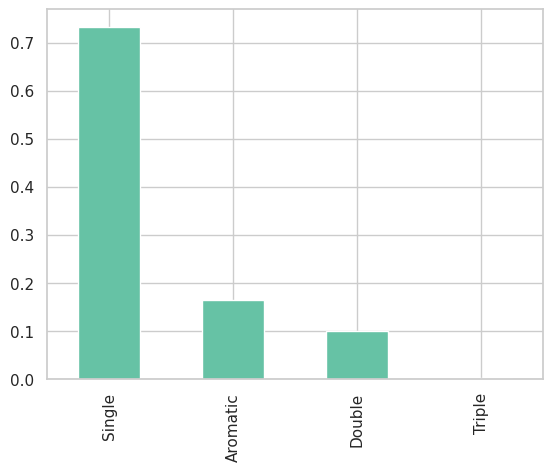

In [ ]:
#Get types of bonds in odorants
bonds = []
for i in range(len(odorants)):
    bonds.extend(odorants['mol'].iloc[i].GetBonds())

bond_types = []
for bond in bonds:
    bond_type = bond.GetBondTypeAsDouble()

    if bond_type == 1.5:
        bond_types.append("Aromatic") 
    elif bond_type == 2:
        bond_types.append("Double")
    elif bond_type == 1:
        bond_types.append("Single")
    elif bond_type == 3:
        bond_types.append("Triple")
    else:
        bond_types.append("Other")

#Plot percentage of bond types in odorants
bond_types = pd.Series(bond_types)
print(bond_types.value_counts(normalize=True))
bond_types.value_counts(normalize=True).plot(kind='bar')
plt.show()

Single      0.721854
Aromatic    0.183872
Double      0.093494
Triple      0.000779
dtype: float64


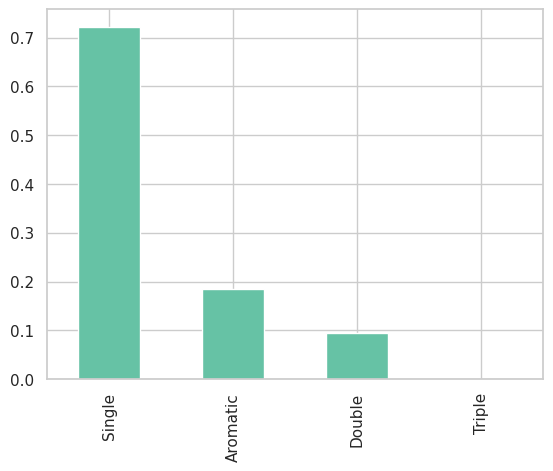

In [ ]:
#Get types of bonds in odorless
bonds = []
for i in range(len(odorless)):
    bonds.extend(odorless['mol'].iloc[i].GetBonds())
    
bond_types = []
for bond in bonds:
    bond_type = bond.GetBondTypeAsDouble()

    if bond_type == 1.5:
        bond_types.append("Aromatic") 
    elif bond_type == 2:
        bond_types.append("Double")
    elif bond_type == 1:
        bond_types.append("Single")
    elif bond_type == 3:
        bond_types.append("Triple")
    else:
        bond_types.append("Other")

#Plot percentage of bond types in odorless
bond_types = pd.Series(bond_types)
print(bond_types.value_counts(normalize=True))
bond_types.value_counts(normalize=True).plot(kind='bar')
plt.show()